# Brain Tumor Detection Using a CNN

Uploading Necessary Libraries

In [ ]:
import numpy as np 
import os
from os import listdir
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
import imutils
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.layers import Conv2D,Dropout,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Loading Images and Making Working Directories

In [2]:
image_dir="./Data/brain_tumor_dataset/"

In [3]:
original_datasize_yes = len(os.listdir(image_dir+'/yes'))
original_datasize_no = len(os.listdir(image_dir+'/no'))

print(f'Original number of images for yes class {original_datasize_yes}')
print(f'Original number of images for no class {original_datasize_no}')

Original number of images for yes class 155
Original number of images for no class 98


In [4]:
os.makedirs('./working/augmented-images')
os.makedirs('./working/augmented-images/yes')
os.makedirs('./working/augmented-images/no')

Image Augmentation

In [4]:
def augment_data(file_dir, no_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=8, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > no_generated_samples:
                    break

In [5]:
augmented_data_path ='./working/augmented-images/'

In [6]:

augment_data(file_dir=image_dir+'yes',no_generated_samples=8, save_to_dir=augmented_data_path+'yes')
augment_data(file_dir=image_dir+'no', no_generated_samples=12, save_to_dir=augmented_data_path+'no')

In [6]:
dir_aug_imagesDir = os.listdir(augmented_data_path)
aug_images_paths = [os.path.join(augmented_data_path, path) for path in dir_aug_imagesDir]

Count of images in both classes

In [7]:
aug_images_dic = {}
for path in aug_images_paths:
    head, tail = os.path.split(path)
    aug_images_dic[tail] = len(os.listdir(path))

In [8]:
num_of_images_in_a_class = ["{}: {}".format(key, aug_images_dic[key]) for key in aug_images_dic]
print(num_of_images_in_a_class)

['no: 1273', 'yes: 1395']


Loading images and data into X and y numpy arrays

In [9]:
def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            print(image)
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)

    print(X)
    print(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [10]:
augmented_yes =augmented_data_path+'yes'
augmented_no = augmented_data_path+'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

[[[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.00392157 0.00392157 0.00392157]
  ...
  [0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]


In [11]:
def plot_sample_images(X, y, n=40):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

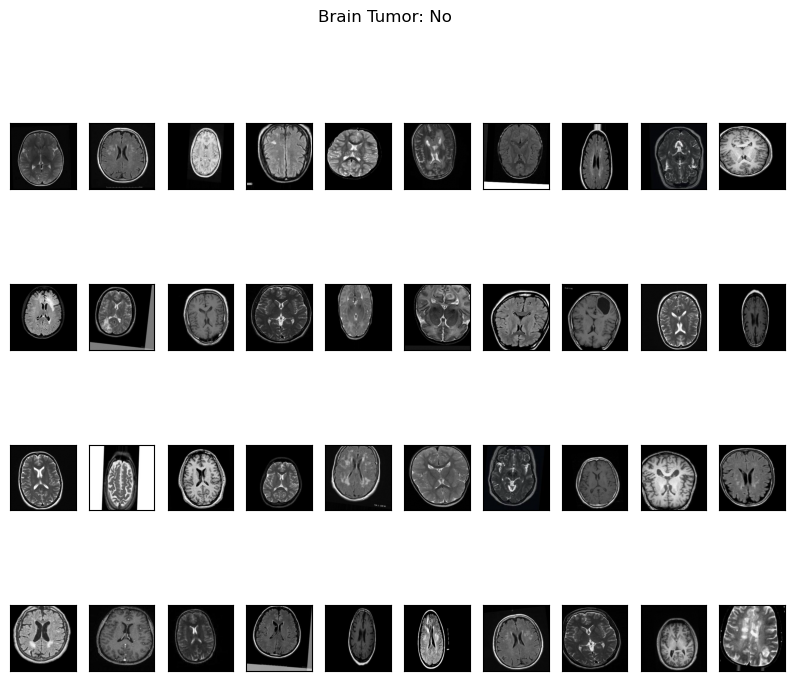

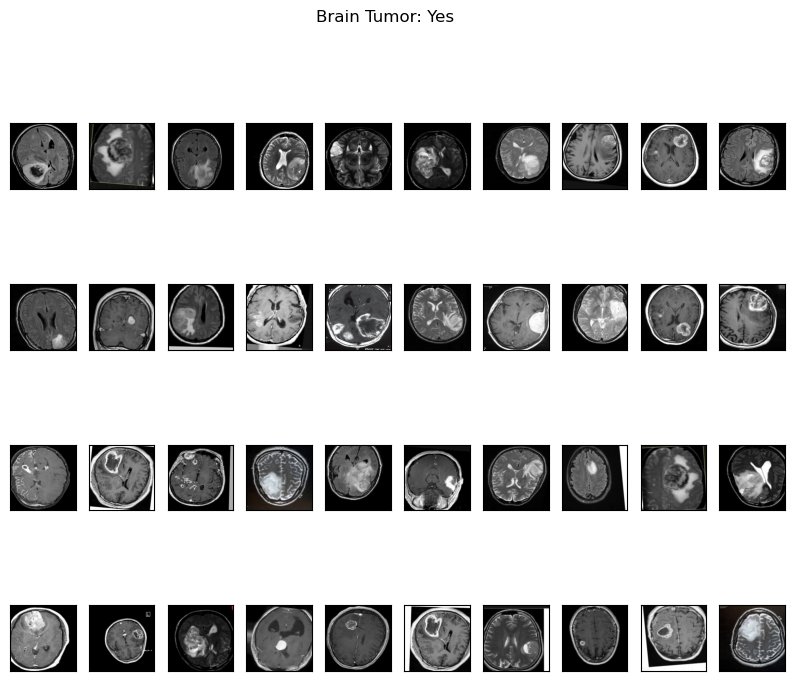

In [12]:
plot_sample_images(X, y)

Train, Test, Valtidation Data Split

In [12]:
def split_data(X, y, test_size=0.2):
       
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [13]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [14]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 1867
number of validation examples = 401
number of test examples = 400


In [15]:
print(X_train.shape)

(1867, 240, 240, 3)


Building the Model (using keras sequential)

In [29]:
model_1 = Sequential()

model_1.add(Conv2D(32, (5,5), strides = (1,1), padding='valid', input_shape=X_train.shape[1:], activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.2))

model_1.add(Conv2D(16, (3,3), strides = (2,2), activation='relu'))

model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.2))

model_1.add(Flatten())
model_1.add(Dense(1, activation='sigmoid'))

model_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 236, 236, 32)      2432      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 118, 118, 32)     0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 118, 118, 32)      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 58, 58, 16)        4624      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 29, 29, 16)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 29, 29, 16)       

In [30]:

# Let's train the model
model_1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_1.fit(X_train, y_train,
              batch_size=32,
              epochs=16,
              validation_data=(X_val, y_val))

Epoch 1/16
59/59 [==============================] - 25s 405ms/step - loss: 0.6136 - accuracy: 0.6845 - val_loss: 0.5501 - val_accuracy: 0.7307
Epoch 2/16
59/59 [==============================] - 24s 402ms/step - loss: 0.5219 - accuracy: 0.7424 - val_loss: 0.4930 - val_accuracy: 0.7781
Epoch 3/16
59/59 [==============================] - 23s 394ms/step - loss: 0.4630 - accuracy: 0.7777 - val_loss: 0.4719 - val_accuracy: 0.7955
Epoch 4/16
59/59 [==============================] - 23s 396ms/step - loss: 0.4353 - accuracy: 0.7890 - val_loss: 0.4515 - val_accuracy: 0.7731
Epoch 5/16
59/59 [==============================] - 23s 396ms/step - loss: 0.3782 - accuracy: 0.8307 - val_loss: 0.5309 - val_accuracy: 0.7357
Epoch 6/16
59/59 [==============================] - 23s 396ms/step - loss: 0.3420 - accuracy: 0.8490 - val_loss: 0.5386 - val_accuracy: 0.7506
Epoch 7/16
59/59 [==============================] - 24s 408ms/step - loss: 0.3063 - accuracy: 0.8645 - val_loss: 0.5496 - val_accuracy: 0.7681

In [31]:
history = model_1.history.history

In [22]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

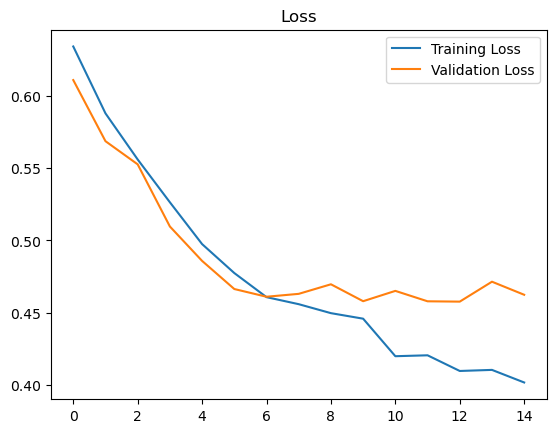

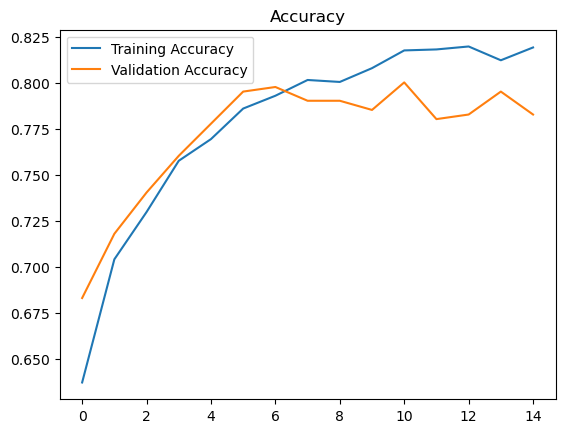

In [20]:
plot_metrics(history)

In [21]:
def prepare(file):
    img_array = cv2.imread(file)
    new_array = cv2.resize(img_array, (IMG_WIDTH,IMG_HEIGHT))
    plt.imshow(new_array)
    print(new_array.shape)
    return new_array.reshape(-1, IMG_WIDTH, IMG_HEIGHT, 3)
#image = testX[1]#your image path



In [22]:
CATAGORIES = ['No', 'Yes']

(240, 240, 3)
1/1 [==============================] - 0s 19ms/step
[[1.]]
[1.0]


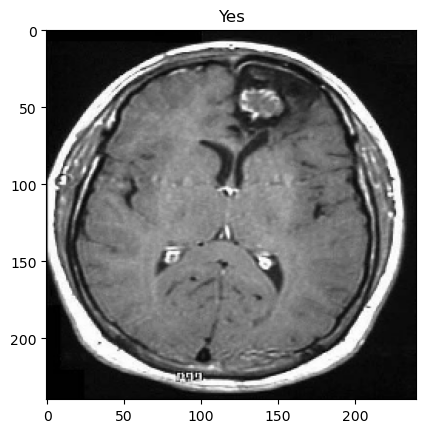

In [25]:
image='./Data/brain_tumor_dataset/yes/Y12.jpg'
prediction = model_1.predict([prepare(image)])
print(prediction)
prediction = list(prediction[0])
#print(CATAGORIES[prediction.index(max(prediction))])
print(prediction)
temp=CATAGORIES[int(prediction[0])]
plt.title(temp)
plt.show()

In [102]:
X_test[5].shape

(240, 240, 3)

In [26]:
prediction = model_1.predict(X_test[385].reshape(-1, IMG_WIDTH, IMG_HEIGHT, 3))
print(prediction)

1/1 [==============================] - 0s 52ms/step
[[0.06138544]]


In [27]:
true_label = y_test[385]
print(true_label)

[0]


Adding L2 Regularization 

In [69]:
model_2 = Sequential()

model_2.add(Conv2D(32, (5,5), strides = (1,1), padding='valid', input_shape=X_train.shape[1:], activation='relu', kernel_regularizer =tf.keras.regularizers.l2( l=0.01)))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.2))

model_2.add(Conv2D(16, (3,3), strides = (2,2), activation='relu', kernel_regularizer =tf.keras.regularizers.l2( l=0.015)))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.2))

model_2.add(Flatten())
model_2.add(Dense(1, activation='sigmoid'))

model_2.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 236, 236, 32)      2432      
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 118, 118, 32)     0         
 g2D)                                                            
                                                                 
 dropout_40 (Dropout)        (None, 118, 118, 32)      0         
                                                                 
 conv2d_41 (Conv2D)          (None, 58, 58, 16)        4624      
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 29, 29, 16)       0         
 g2D)                                                            
                                                                 
 dropout_41 (Dropout)        (None, 29, 29, 16)      

In [53]:
model_2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_2.fit(X_train, y_train,
              batch_size=32,
              epochs=8,
              validation_data=(X_val, y_val))

Epoch 1/8
59/59 [==============================] - 25s 409ms/step - loss: 0.8555 - accuracy: 0.6931 - val_loss: 0.7798 - val_accuracy: 0.6808
Epoch 2/8
59/59 [==============================] - 25s 416ms/step - loss: 0.6967 - accuracy: 0.7193 - val_loss: 0.6858 - val_accuracy: 0.7057
Epoch 3/8
59/59 [==============================] - 24s 401ms/step - loss: 0.5957 - accuracy: 0.7493 - val_loss: 0.5734 - val_accuracy: 0.7756
Epoch 4/8
59/59 [==============================] - 24s 401ms/step - loss: 0.5441 - accuracy: 0.7799 - val_loss: 0.5586 - val_accuracy: 0.7681
Epoch 5/8
59/59 [==============================] - 24s 399ms/step - loss: 0.4759 - accuracy: 0.8179 - val_loss: 0.5182 - val_accuracy: 0.7656
Epoch 6/8
59/59 [==============================] - 24s 403ms/step - loss: 0.4553 - accuracy: 0.8141 - val_loss: 0.5426 - val_accuracy: 0.7556
Epoch 7/8
59/59 [==============================] - 24s 409ms/step - loss: 0.4161 - accuracy: 0.8441 - val_loss: 0.5039 - val_accuracy: 0.7905
Epoch 

In [54]:
history2 = model_2.history.history

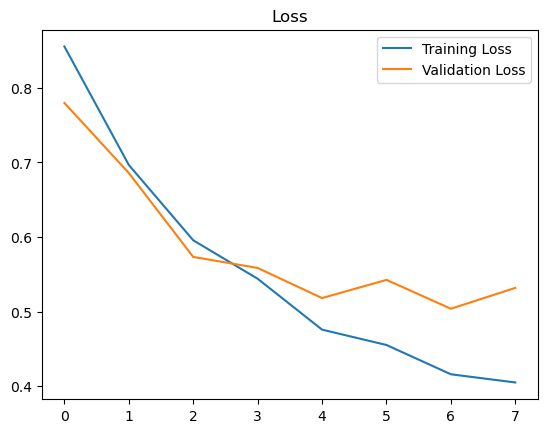

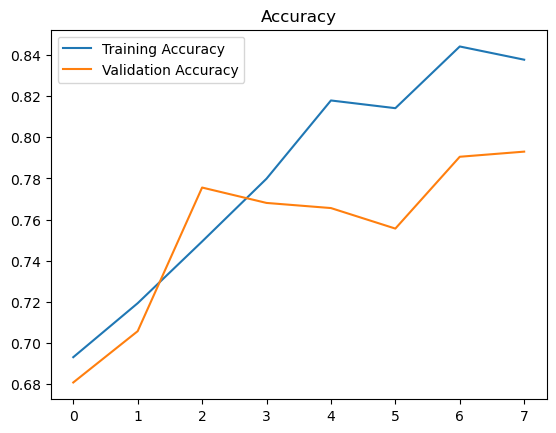

In [55]:
plot_metrics(history2)

Lets try Transfer Learning

In [16]:
feature_layers = [
    Conv2D(64, (5,5), strides = (2,2), padding='same', input_shape=X_train.shape[1:], activation='relu', kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    Conv2D(32, (3,3), strides = (2,2), activation='relu', kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    Flatten()
]

In [17]:
classification_layers = [
    Dense(1, activation='sigmoid')
]

In [27]:
model_3 = Sequential(feature_layers + classification_layers)

In [36]:
model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 60, 60, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 32)       

In [29]:
model_3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_3.fit(X_train, y_train,
              batch_size=32,
              epochs=10,
              validation_data=(X_val, y_val))

Epoch 1/10
59/59 [==============================] - 7s 108ms/step - loss: 0.4279 - accuracy: 0.8249 - val_loss: 0.4860 - val_accuracy: 0.8055
Epoch 2/10
59/59 [==============================] - 6s 99ms/step - loss: 0.4343 - accuracy: 0.8222 - val_loss: 0.4756 - val_accuracy: 0.8005
Epoch 3/10
59/59 [==============================] - 6s 97ms/step - loss: 0.4213 - accuracy: 0.8345 - val_loss: 0.4785 - val_accuracy: 0.8030
Epoch 4/10
59/59 [==============================] - 6s 97ms/step - loss: 0.4352 - accuracy: 0.8163 - val_loss: 0.4698 - val_accuracy: 0.8030
Epoch 5/10
59/59 [==============================] - 6s 97ms/step - loss: 0.4205 - accuracy: 0.8291 - val_loss: 0.4707 - val_accuracy: 0.8130
Epoch 6/10
59/59 [==============================] - 6s 96ms/step - loss: 0.4239 - accuracy: 0.8275 - val_loss: 0.4817 - val_accuracy: 0.7955
Epoch 7/10
59/59 [==============================] - 6s 97ms/step - loss: 0.4259 - accuracy: 0.8179 - val_loss: 0.4869 - val_accuracy: 0.7955
Epoch 8/10
5

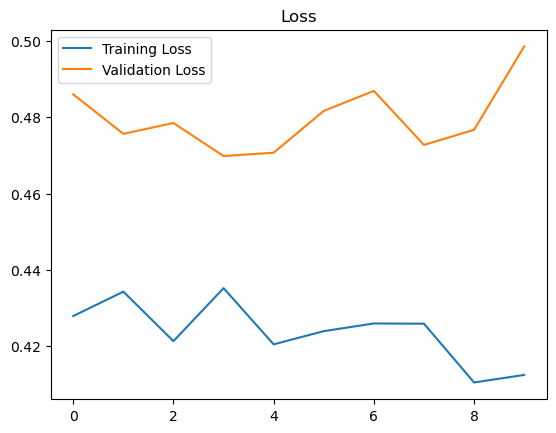

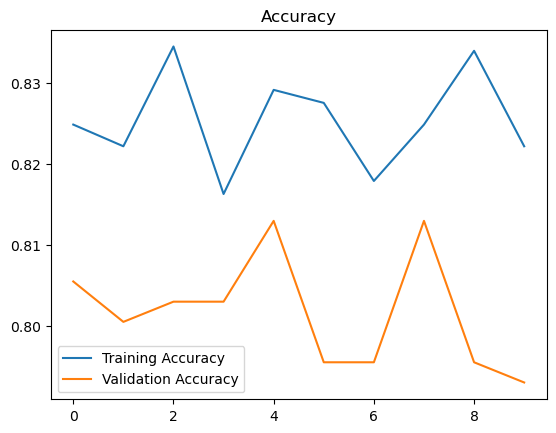

In [30]:
history3 = model_3.history.history
plot_metrics(history3)

In [31]:
for l in feature_layers:
    l.trainable = False

In [32]:
model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 60, 60, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 32)       

In [33]:
model_3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_3.fit(X_train, y_train,
              batch_size=32,
              epochs=16,
              validation_data=(X_val, y_val))

Epoch 1/16
59/59 [==============================] - 7s 103ms/step - loss: 0.4159 - accuracy: 0.8297 - val_loss: 0.4818 - val_accuracy: 0.8005
Epoch 2/16
59/59 [==============================] - 6s 97ms/step - loss: 0.4168 - accuracy: 0.8200 - val_loss: 0.4739 - val_accuracy: 0.8005
Epoch 3/16
59/59 [==============================] - 6s 97ms/step - loss: 0.4076 - accuracy: 0.8238 - val_loss: 0.4726 - val_accuracy: 0.8005
Epoch 4/16
59/59 [==============================] - 6s 98ms/step - loss: 0.4137 - accuracy: 0.8377 - val_loss: 0.4716 - val_accuracy: 0.7980
Epoch 5/16
59/59 [==============================] - 6s 96ms/step - loss: 0.4109 - accuracy: 0.8302 - val_loss: 0.4730 - val_accuracy: 0.8005
Epoch 6/16
59/59 [==============================] - 6s 96ms/step - loss: 0.4068 - accuracy: 0.8372 - val_loss: 0.4878 - val_accuracy: 0.7905
Epoch 7/16
59/59 [==============================] - 6s 97ms/step - loss: 0.4162 - accuracy: 0.8302 - val_loss: 0.4982 - val_accuracy: 0.8055
Epoch 8/16
5

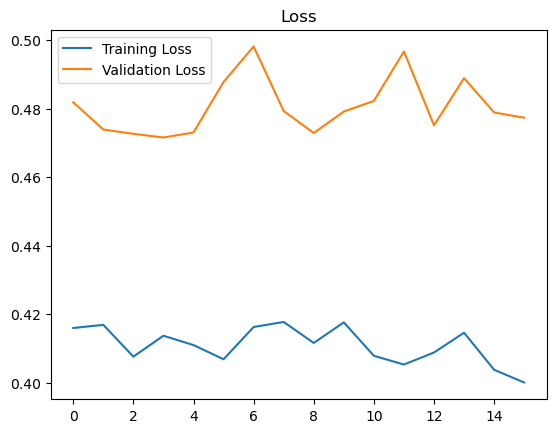

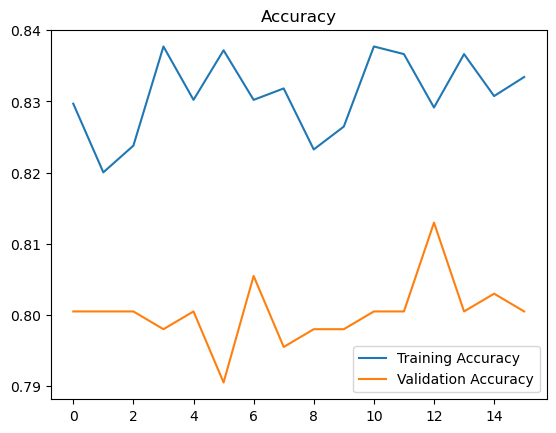

In [35]:
history3 = model_3.history.history
plot_metrics(history3)